# CMS General Hospital Information - Exploratory Data Analysis
---
### Which states/counties have the lowest quality of care metrics within their hospitals?
---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from get_cleaned_cms import cms

In [2]:
# Define custom color palette for all plots by state
custom_palette = {'Mississippi': '#5899c6', 'Louisiana': '#ff9f4b', 'Alabama': '#61b862'}

In [3]:
# Get info about cleaned hpsa dataframe
cms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2704 entries, 0 to 2703
Data columns (total 53 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Year                                                   2704 non-null   int64  
 1   Quarter                                                2704 non-null   object 
 2   Facility ID                                            2704 non-null   object 
 3   Facility Name                                          2704 non-null   object 
 4   City                                                   2704 non-null   object 
 5   State                                                  2704 non-null   object 
 6   ZIP Code                                               2704 non-null   int64  
 7   Hospital Type                                          2704 non-null   object 
 8   Hospital Ownership                              

---
### How many hospitals from each state are represented for each year?  How many counties?

In [4]:
# Get hospital sample size
cms.groupby(['Year', 'State'])['Facility ID'].count()

Year  State      
2016  Alabama         89
      Louisiana      122
      Mississippi     96
2017  Alabama         91
      Louisiana      121
      Mississippi     95
2018  Alabama         91
      Louisiana      119
      Mississippi     95
2019  Alabama         99
      Louisiana      154
      Mississippi    101
2020  Alabama         97
      Louisiana      153
      Mississippi    100
2021  Alabama         99
      Louisiana      156
      Mississippi    101
2022  Alabama         98
      Louisiana      158
      Mississippi    103
2023  Alabama        100
      Louisiana      161
      Mississippi    105
Name: Facility ID, dtype: int64

In [5]:
# Get county sample size
cms.groupby(['Year', 'State'])['Common State County FIPS Code'].nunique()

Year  State      
2016  Alabama        58
      Louisiana      56
      Mississippi    75
2017  Alabama        59
      Louisiana      56
      Mississippi    74
2018  Alabama        59
      Louisiana      56
      Mississippi    74
2019  Alabama        59
      Louisiana      57
      Mississippi    74
2020  Alabama        59
      Louisiana      57
      Mississippi    72
2021  Alabama        59
      Louisiana      57
      Mississippi    72
2022  Alabama        59
      Louisiana      57
      Mississippi    73
2023  Alabama        59
      Louisiana      57
      Mississippi    73
Name: Common State County FIPS Code, dtype: int64

---
#### For each year and state, how many hospitals were given star ratings?

In [6]:
# Get number of hospitals with star ratings sample size
cms.groupby(['Year', 'State'])['Hospital overall rating'].count()

Year  State      
2016  Alabama        79
      Louisiana      80
      Mississippi    63
2017  Alabama        79
      Louisiana      79
      Mississippi    63
2018  Alabama        81
      Louisiana      78
      Mississippi    64
2019  Alabama        77
      Louisiana      81
      Mississippi    65
2020  Alabama        76
      Louisiana      76
      Mississippi    62
2021  Alabama        70
      Louisiana      72
      Mississippi    54
2022  Alabama        65
      Louisiana      64
      Mississippi    49
2023  Alabama        61
      Louisiana      61
      Mississippi    49
Name: Hospital overall rating, dtype: int64

---
### Which states have the highest average hospital overall star rating across all years?
#### **Answer: Louisiana (3.05 stars), followed by Alabama (2.97 stars) and Mississippi (2.64 stars).**

In [7]:
cms.groupby('State')['Hospital overall rating'].describe()

,count,mean,std,min,25%,50%,75%,max
State,,,,,,,,
Alabama,588.0,2.972789,0.88096,1.0,2.0,3.0,4.0,5.0
Louisiana,591.0,3.052453,0.929164,1.0,2.0,3.0,4.0,5.0
Mississippi,469.0,2.641791,0.969427,1.0,2.0,3.0,3.0,5.0


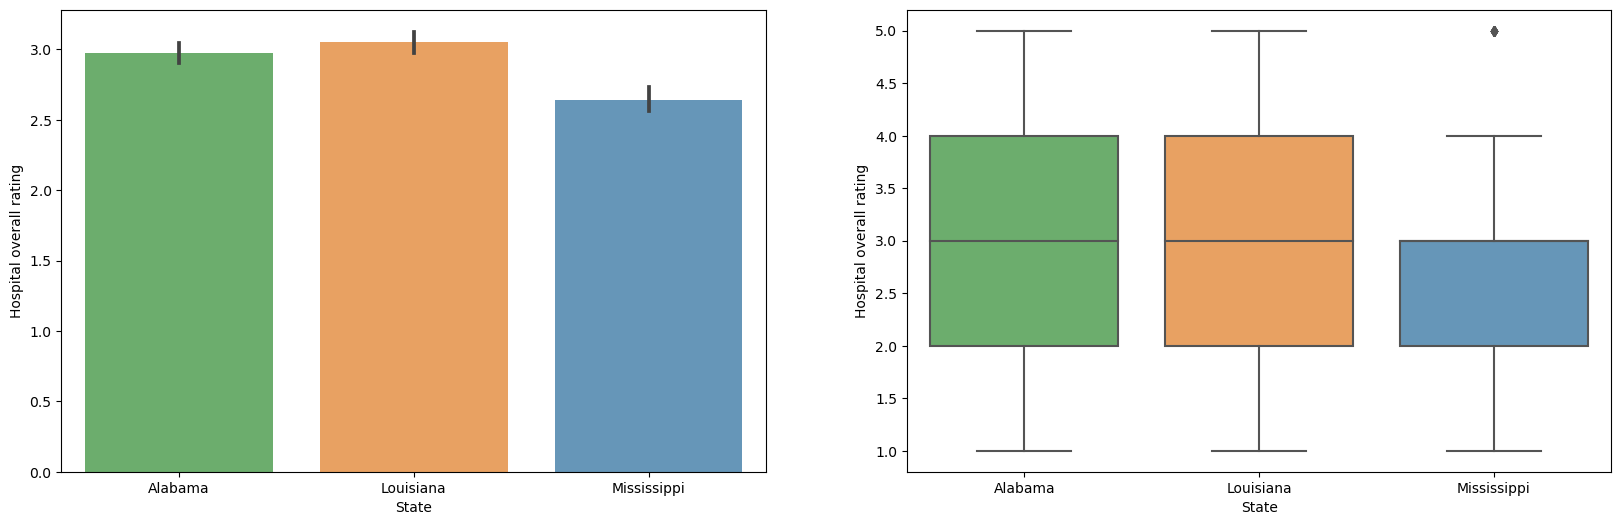

In [8]:
# Create barplot and boxplot for Hospital overall rating by state
cms_cleaned = cms.dropna(subset = ['Hospital overall rating', 'State'])

plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_cleaned, x = 'State', y = 'Hospital overall rating', palette = custom_palette)

plt.subplot(1, 2, 2)
sns.boxplot(cms_cleaned, x = 'State', y = 'Hospital overall rating', palette = custom_palette)

plt.show()

---
### How has the average overall hospital star rating changed over time by state?
#### **Answer: Mississippi has star ratings consistently between 2.4 and 2.8 stars, with ratings dropping below 2.7 over the last three years.  Louisiana & Alabama have star ratings consistently between 2.9 and 3.1, however both have received lower star ratings than normal in 2023 (2.8 and 2.6, respectively).**

In [9]:
cms.groupby(['State', 'Year'])['Hospital overall rating'].describe()

count      mean       std  min   25%  50%  75%  max
State       Year                                                     
Alabama     2016   79.0  3.050633    0.7143  2.0   3.0  3.0  3.0  5.0
            2017   79.0  3.050633    0.7143  2.0   3.0  3.0  3.0  5.0
            2018   81.0  2.975309  0.805843  2.0   2.0  3.0  4.0  5.0
            2019   77.0  2.896104   1.00766  1.0   2.0  3.0  4.0  5.0
            2020   76.0  3.039474  0.972156  2.0   2.0  3.0  4.0  5.0
            2021   70.0  3.085714  0.974201  1.0   2.0  3.0  4.0  5.0
            2022   65.0  3.015385  0.856817  2.0   2.0  3.0  4.0  5.0
            2023   61.0  2.606557  0.935925  1.0   2.0  3.0  3.0  5.0
Louisiana   2016   80.0     3.125  0.682048  1.0   3.0  3.0  4.0  5.0
            2017   79.0  3.126582  0.686259  1.0   3.0  3.0  4.0  5.0
            2018   78.0  3.115385  0.980071  1.0  2.25  3.0  4.0  5.0
            2019   81.0  3.012346  0.873124  1.0   2.0  3.0  4.0  5.0
            2020   76.0  2.921053  0.905732  1.0   2.0  3.0  3.0  5.0
            2021   72.0  3.194444  1.121353  1.0  2.75  3.0  4.0  5.0
            2022   64.0    3.0625   1.12511  1.0   2.0  3.0  4.0  5.0
            2023   61.0  2.819672  1.024828  1.0   2.0  3.0  4.0  5.0
Mississippi 2016   63.0  2.777778  0.750149  1.0   2.0  3.0  3.0  4.0
            2017   63.0  2.777778  0.750149  1.0   2.0  3.0  3.0  4.0
            2018   64.0   2.65625  0.995526  1.0   2.0  3.0  3.0  5.0
            2019   65.0  2.569231   0.86547  1.0   2.0  3.0  3.0  5.0
            2020   62.0  2.725806  1.042842  1.0   2.0  3.0  3.0  5.0
            2021   54.0  2.574074   1.07461  1.0   2.0  2.0  3.0  5.0
            2022   49.0  2.408163  1.097694  1.0   2.0  2.0  3.0  5.0
            2023   49.0  2.571429  1.190238  1.0   2.0  2.0  3.0  5.0

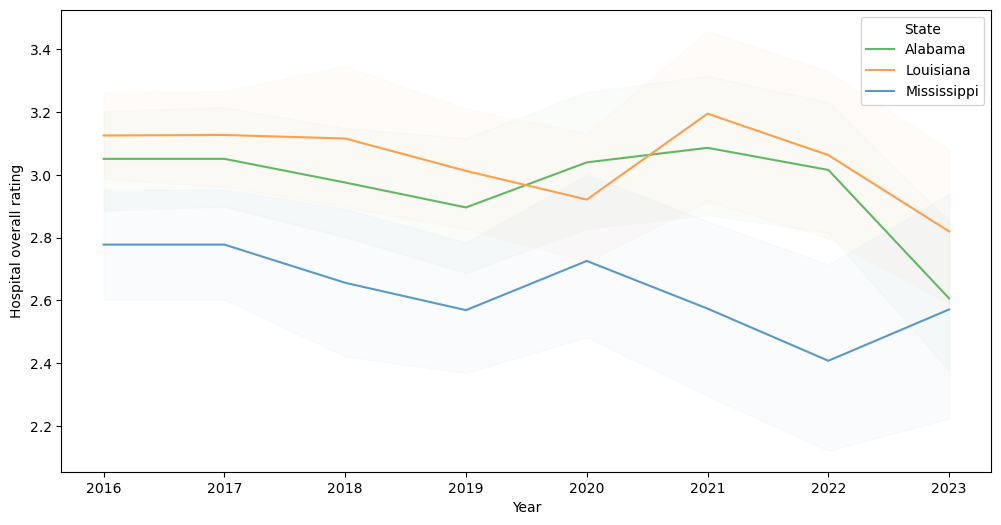

In [10]:
# Create line plot for Hospital overall rating by year and state
plt.figure(figsize = (12, 6))

sns.lineplot(cms, x = 'Year', y = 'Hospital overall rating', hue = 'State',
             palette = custom_palette, err_kws={'alpha': 0.03})

plt.show()

---
### How do the average hospital star ratings compare in shortage areas versus non-shortage areas for these states across all years?
#### **Answer: Surprisingly, for Mississippi & Alabama, hospitals in counties designated as shortage areas have star ratings that are HIGHER on average compared to hospitals in non-shortage areas.  There is no difference in star ratings between hospitals in shortage vs. non-shortage counties for Louisiana.**

In [11]:
cms.groupby(['State', 'County HPSA Status'])['Hospital overall rating'].describe()

count      mean       std  min  25%  50%  75%  \
State       County HPSA Status                                                  
Alabama     Non-Shortage Area   342.0  2.769006  0.857521  1.0  2.0  3.0  3.0   
            Shortage Area       246.0  3.256098  0.835112  1.0  3.0  3.0  4.0   
Louisiana   Non-Shortage Area   455.0  3.048352  0.967462  1.0  2.0  3.0  4.0   
            Shortage Area       136.0  3.066176  0.790707  1.0  3.0  3.0  4.0   
Mississippi Non-Shortage Area   268.0   2.44403  0.990896  1.0  2.0  2.0  3.0   
            Shortage Area       201.0  2.905473  0.875226  1.0  2.0  3.0  3.0   

                                max  
State       County HPSA Status       
Alabama     Non-Shortage Area   5.0  
            Shortage Area       5.0  
Louisiana   Non-Shortage Area   5.0  
            Shortage Area       5.0  
Mississippi Non-Shortage Area   5.0  
            Shortage Area       5.0

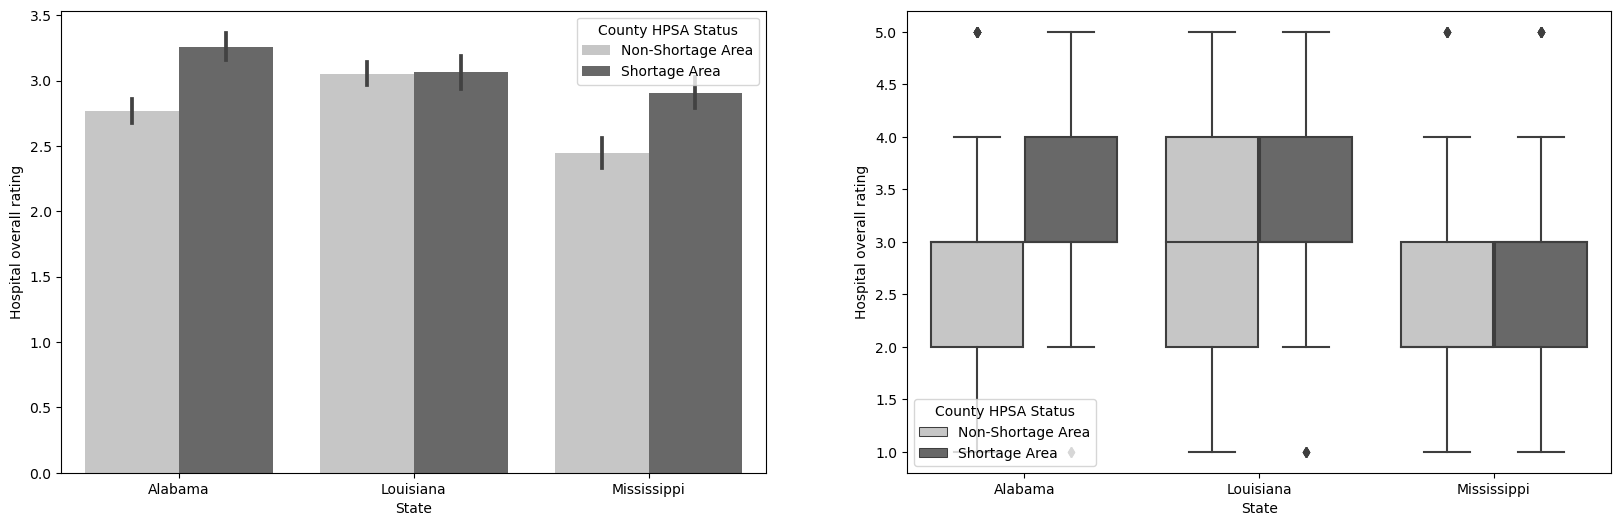

In [12]:
# Create barplot and boxplot for Hospital overall rating by HPSA County Status and state
cms_cleaned = cms.dropna(subset = ['Hospital overall rating', 'County HPSA Status', 'State'])

plt.figure(figsize = (20, 6))

plt.subplot(1, 2, 1)
sns.barplot(cms_cleaned, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'Greys')

plt.subplot(1, 2, 2)
sns.boxplot(cms_cleaned, x = 'State', y = 'Hospital overall rating',
            hue = 'County HPSA Status', palette = 'Greys')

plt.show()av